# A naive-bayes sentiment classifier for movie reviews

## Steps
1. Read training data from each file along with it's class.
2. Tokenize the words.
3. Lemitization
4. Get word token count vectors
5. Train
6. Run test

## Formula for Naive Bayes Classifier

$$c_{NB} = argmax_{c \in C}(log{}P(c) + \sum_{i\in positions} log{}P(w_i|c))$$

In this training data, the probability of both positive and negative class is $1/2$ as there are equal number of positive and negative training data sets.
Hence,
$$log{}P(c) = log{}(1/2)$$

The second part of the equation can be re-written as below
$$log{}\frac{count(w,c) + 1}{\sum_{w_1\in V}(count(w_1,c) + 1)}$$

In [ ]:
##
## Test: Preprocessing
##

import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

punctuations.add("''")
punctuations.add('``')


lemmataizer = WordNetLemmatizer()

def preprocess_file_contents(lines):
    # Combine everything to process all lines at once
    file_content = " ".join(lines)
    
    tokens = word_tokenize(file_content)
    
    processed_tokens = []
    
    for token in tokens:
        lower_token = token.lower()
        if lower_token in stop_words or token in punctuations:
            continue
        
        processed_tokens.append(lemmataizer.lemmatize(token))
    
    return processed_tokens

file = "0_9.txt"

with open("data/aclImdb/train/pos/0_9.txt", "r") as f:
    tokens = preprocess_file_contents(f.readlines())
    print(set(tokens))

In [1]:
##
## Helper method
##

import os

def get_dataset_file_list(dir_path, filter_extension = None):
    file_path_list = []
    
    for path in os.listdir(dir_path):
        # check if current path is a file
        absolute_path = os.path.join(dir_path, path)
        # Make sure the path is a file and it is a .txt file (Ignore OS hidden stuff like .DS_Store
        if os.path.isfile(absolute_path):
            if filter_extension is not None:
                if os.path.splitext(path)[-1] != filter_extension:
                    continue
            
            file_path_list.append(absolute_path)
    
    return file_path_list

In [2]:
##
## Count word features in all the dataset
##

from sklearn.feature_extraction.text import CountVectorizer

# Returns sparse_tree_matrix and the list of features (words)
def build_feature_count_matrix(train_dataset):
    # Extract all filepath from array of ( Absolute filepath, Class ) tupple
    all_file_path_list = [ data[0] for data in train_dataset ]

    # Fit transforms
    count_vectorizer = CountVectorizer(input="filename")
    sparse_tree_matrix = count_vectorizer.fit_transform(all_file_path_list)
    features = count_vectorizer.get_feature_names_out()
        
    return count_vectorizer, sparse_tree_matrix, features

In [ ]:
##
## Build data frame from sparsetree matrix and features
##

import numpy as np
import pandas as pd

def build_feature_data_frame(sparse_tree_matrix, features):
    # Aggregate of feature count in all documents
    feature_count_aggregate = sparse_tree_matrix.sum(axis=0)

    # Put data in numpy array
    data = np.append(sparse_tree_matrix.toarray(), feature_count_aggregate, axis=0)

    # Last row of the df is the total count
    return pd.DataFrame(data, columns = features)

In [3]:
##
## Calculate Log prior probability
##

import math
from collections import Counter

# Train Dataset => List of tupple of filepath and class
def calculate_log_prior_probability(train_dataset):
    log_prior = {}
    train_dataset_class_count = Counter(file_class[1] for file_class in train_dataset)
    train_dataset_total_count = len(train_dataset)

    for k in train_dataset_class_count.elements():
        log_prior[k] = math.log(train_dataset_class_count[k] / train_dataset_total_count)
        
    return log_prior

In [4]:
##
## Count features in each class
##

# {class_01 => { feature_id_01 => count, feature_id_02 => count }, class_02 => {..} }
def count_features_in_class(train_dataset, sparse_tree_matrix):
    count_map = {}

    cmatrix = sparse_tree_matrix.tocoo()
    for index, feature, count in zip(cmatrix.row, cmatrix.col, cmatrix.data):
        class_enum = train_dataset[index][1]

        if class_enum not in count_map:
            count_map[class_enum] = {}

        if feature not in count_map[class_enum]:
            count_map[class_enum][feature] = 0

        count_map[class_enum][feature] += count
        
    return count_map
    
# Print Map
#print(class_feature_count_map)

# Debugging common keys
#common = class_feature_count_map[MovieReviewClass.POS].keys() & class_feature_count_map[MovieReviewClass.NEG].keys()
#print(common)
#count_vect.get_feature_names_out()[257]

In [5]:
##
## Calculates log likelihood for P(feature|class)
##

# {class_01 => {feature_id_01 => loglikelihood }}
def calculate_log_likelihood(class_feature_count, total_feature_count):
    log_likelihood = {}

    for clazz, feature_count in class_feature_count.items():
        total_feature_count_in_class = sum([ count for feature, count in feature_count.items()]) + total_feature_count

        if clazz not in log_likelihood:
            log_likelihood[clazz] = {}

        for feature, count in feature_count.items():
            log_likelihood[clazz][feature] = math.log((count + 1) / total_feature_count_in_class)
            
    return log_likelihood

In [6]:
##
## Train Naive Bayes from train_dataset and class_list
##

def train_naive_bayes(train_dataset):
    log_prior = calculate_log_prior_probability(train_dataset)
    
    count_vectorizer, sparse_tree_matrix, features = build_feature_count_matrix(train_dataset)
    class_feature_count = count_features_in_class(train_dataset, sparse_tree_matrix)

    log_likelihood = calculate_log_likelihood(class_feature_count, len(features))
    
    return count_vectorizer, log_prior, log_likelihood

In [7]:
##
## Prepare constants for dataset
##

from enum import Enum

class Class(Enum):
    POS = 1
    NEG = 2

CLASS_LIST = [ Class.POS, Class.NEG ]

DATASET_BASE_DIR = "data/aclImdb/"
TRAIN_DATASET_BASE_DIR = DATASET_BASE_DIR + "train/"
TEST_DATASET_BASE_DIR = DATASET_BASE_DIR + "test/"

CLASS_DIR = { Class.POS : "pos", Class.NEG : "neg" }

# Array of ( Absolute filepath, Class ) tupple
train_dataset = []
for c in CLASS_LIST:
    dir_path = TRAIN_DATASET_BASE_DIR + CLASS_DIR[c]
    train_dataset.extend([ (filepath, c) for filepath in get_dataset_file_list(dir_path, ".txt") ])
    
print("Found {} files in training dataset.".format(len(train_dataset)))

print("Training Naive Bayes")

count_vectorizer, log_prior, log_likelihood = train_naive_bayes(train_dataset)

print("Completed training Naive Bayes")

Found 25000 files in training dataset.
Completed training Naive Bayes


In [8]:
def predict_class(test_tokens, log_prior, log_likelihood, class_list, feature_id_map):
    class_probability = {}
    
    for clazz in class_list:
        class_probability[clazz] = log_prior[clazz]
        
        for word in test_tokens:
            if word in feature_id_map:
                feature_id = feature_id_map[word]
                feature_log_likelihood_for_class = log_likelihood[clazz][feature_id] if feature_id in log_likelihood[clazz] else 0
                
                class_probability[clazz] += feature_log_likelihood_for_class
    
    return max(class_probability, key=class_probability.get)

In [20]:
# Array of ( Absolute filepath, Class ) tupple
test_dataset = []
for c in CLASS_LIST:
    dir_path = TEST_DATASET_BASE_DIR + CLASS_DIR[c]
    test_dataset.extend([ (filepath, c) for filepath in get_dataset_file_list(dir_path, ".txt") ])


tokenizer = count_vectorizer.build_tokenizer()
features = count_vectorizer.get_feature_names_out()
feature_id_map = dict(zip(features, list(range(len(features)))))

actual_classes = []
predicted_classes = []

print("Testing {} files".format(len(test_dataset)))
for test_filepath, actual_clazz in test_dataset:
    with open(test_filepath, "r") as f:
        test_tokens = tokenizer(f.read())

        predicted_clazz = predict_class(test_tokens, log_prior, log_likelihood, CLASS_LIST, feature_id_map)

        actual_classes.append(actual_clazz.value)
        predicted_classes.append(predicted_clazz.value)

Testing 25000 files


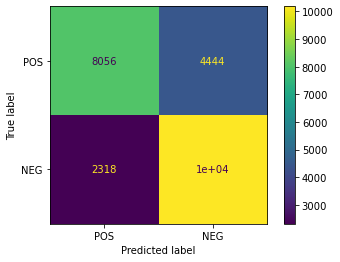

              precision    recall  f1-score   support

         pos       0.78      0.64      0.70     12500
         neg       0.70      0.81      0.75     12500

    accuracy                           0.73     25000
   macro avg       0.74      0.73      0.73     25000
weighted avg       0.74      0.73      0.73     25000



In [21]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(actual_classes, predicted_classes)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["POS", "NEG"])

cm_display.plot()
plt.show()

def transform_list(l):
    return [ "pos" if v == 1 else "neg" for v in l ]

print(metrics.classification_report(transform_list(actual_classes), transform_list(predicted_classes), labels=["pos", "neg"]))